### Baseline Machine Learning Models for Regression

* Decision Tree
* Random Forest

In this notebook we will be exploring a two different Machine Learning models to predict:
1) the odds of a horse winning
2) the purse of a race

Through these models we will also perform feature performance analysis to extract the most critical features in the regression process.

In [29]:
# Import the packages we require for our analysis. 
!pip install wordninja
!pip install num2words

import pandas as pd
import numpy as np

#for pre-processing
import re, string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import wordninja
import num2words
from sklearn.preprocessing import OneHotEncoder

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# For plotting
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Move directory to root (590-Group-Project/)
import os
os.chdir("..")
print(os.getcwd())

/Users/eliserust/Desktop/Papers/Georgetown/Fall 2022/ANLY590/590-Group-Project


#### 1) Load the data

The data is not hosted on the GitHub repo due to its size (Git has a 100MB file size limit). Data can be found in our Google Folder at:
- https://drive.google.com/drive/folders/0ALCmvIZc4E4KUk9PVA

In [31]:
df = pd.read_csv("data/joined_data_without_position.csv")
df.head()

,Unnamed: 0,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,...,Comments,seconds_in_race,humidity,precipcover,precip,temp,maxt,cloudcover,weathertype,snow
0,0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,650,...,"ins,drve5/16,outlate",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
1,1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,650,...,"torail1/2,6p1/8,mild",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
2,2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4,650,...,"prompted2w,folded",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
3,3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5,650,...,"3wturn,alter5p1/8",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
4,4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1,650,...,"3-4w,drve5/16,4w,up",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0


In [32]:
### Examine datatypes
df.dtypes

Unnamed: 0               int64
track_id                object
race_date               object
race_number              int64
program_number          object
weight_carried           int64
jockey                  object
odds                     int64
position_at_finish       int64
distance_id              int64
course_type             object
track_condition         object
run_up_distance          int64
race_type               object
purse                    int64
post_time                int64
last_race_track         object
day_since_last_race     object
Comments                object
seconds_in_race        float64
humidity               float64
precipcover            float64
precip                 float64
temp                   float64
maxt                   float64
cloudcover             float64
weathertype             object
snow                   float64
dtype: object

In [33]:
## Add "winner" column --> 1 if finish position == 1,2,3; 0 else
top=[1,2,3]
df["winner"] = np.where(df["position_at_finish"].isin(top), 1, 0)
print(df["winner"])

0        1
1        1
2        0
3        0
4        1
        ..
15076    1
15077    0
15078    0
15079    0
15080    0
Name: winner, Length: 15081, dtype: int64


In [34]:
## Remove "days" from day_since_last_race variable
df["day_since_last_race"] = df["day_since_last_race"].str[:2]
df["day_since_last_race"]

0        37
1        25
2        37
3        17
4        37
         ..
15076    45
15077    25
15078    18
15079    50
15080    50
Name: day_since_last_race, Length: 15081, dtype: object

In [35]:
# Get number of unique values per feature to see which are categorical vs. continuous
n = df.nunique(axis=0)
print("Number of unique values in each column: \n", n)

Number of unique values in each column: 
 Unnamed: 0             15081
track_id                   3
race_date                217
race_number               13
program_number            20
weight_carried            35
jockey                   178
odds                     656
position_at_finish        14
distance_id               20
course_type                5
track_condition            7
run_up_distance          127
race_type                 12
purse                     70
post_time                360
last_race_track          182
day_since_last_race       97
Comments                9957
seconds_in_race          447
humidity                 215
precipcover               21
precip                    53
temp                     172
maxt                     184
cloudcover               186
weathertype               50
snow                       6
winner                     2
dtype: int64


In [36]:
## Check number of missing values per column --> many models don't accept NaN
df.isna().sum()

Unnamed: 0                0
track_id                  0
race_date                 0
race_number               0
program_number            0
weight_carried            0
jockey                    0
odds                      0
position_at_finish        0
distance_id               0
course_type               0
track_condition           0
run_up_distance           0
race_type                 0
purse                     0
post_time                 0
last_race_track        1993
day_since_last_race    1993
Comments                568
seconds_in_race           0
humidity                  0
precipcover               0
precip                    0
temp                      0
maxt                      0
cloudcover                0
weathertype            5685
snow                      0
winner                    0
dtype: int64

#### 2) Pre-process data for Models

* Text data was already pre-processed (tokenized, stemmed, etc.) in the data cleaning phase but needs to be TFIDF Vectorized
* The rest of the data still needs to be encoded for classification
* Categorical Variables of interest will be:
    - track_id
    - race_date
    - jockey
    - course_type
    - track_condition
    - race_type
    - last_race_track
    - winner
* Numeric Variables of interest will be:
    - weight_carried
    - odds
    - run_up_distance
    - purse
    - *days_since_last_race*
    - seconds_in_race
    - humidity
    - precipcover
    - precip
    - temp
    - maxt
    - cloudcover
    - weathertype
    - snow
* Text Variables
    - Comments

In [37]:
#### Remove redundance variables
df = df.drop(columns=['position_at_finish', 'post_time', 'distance_id'])

# Convert the race number as string.
df['race_number'] = df['race_number'].astype('str')

# Fill day since last race with NA
df['day_since_last_race'] = df['day_since_last_race'].fillna(0)

# Fill the comments column with string None.
df['Comments'] = df['Comments'].fillna('None')

In [38]:
### Encode the categorical variables
# First, change the type of the specified columns to "category". This will assign a "code" to each unique category value.
categorical_columns = ["track_id", "race_date", "jockey", "course_type", "track_condition", "race_type", "last_race_track", "winner", "weathertype"]

for col in categorical_columns:
    df[col] = df[col].astype('category') # Set type to category
    df[col] = df[col].cat.codes # replace the strings with their code values.

# View new dataframe
df

,Unnamed: 0,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,course_type,track_condition,...,seconds_in_race,humidity,precipcover,precip,temp,maxt,cloudcover,weathertype,snow,winner
0,0,0,0,1,1,123,42,130,0,3,...,79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,1
1,1,0,0,1,2,120,103,295,0,3,...,79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,1
2,2,0,0,1,3,118,96,180,0,3,...,79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,0
3,3,0,0,1,4,123,83,1280,0,3,...,79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,0
4,4,0,0,1,5,118,119,1150,0,3,...,79.00,73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,15076,2,143,11,3,119,119,1470,0,5,...,83.25,84.02,66.67,0.75,65.6,71.8,71.5,42,0.0,1
15077,15077,2,143,11,4,119,96,1070,0,5,...,83.25,84.02,66.67,0.75,65.6,71.8,71.5,42,0.0,0
15078,15078,2,143,11,6,119,50,1130,0,5,...,69.25,84.02,66.67,0.75,65.6,71.8,71.5,42,0.0,0
15079,15079,2,143,11,7,119,66,460,0,5,...,83.25,84.02,66.67,0.75,65.6,71.8,71.5,42,0.0,0


In [39]:
### Convert numerical features to floats
df = df.astype({'weight_carried':'float','odds':'float', 'run_up_distance':'float', 'purse':'float', 'race_number':'float',
                                'seconds_in_race':'float','humidity':'float','winner':'float',
                                'precipcover':'float','precip':'float','temp':'float','maxt':'float','cloudcover':'float',
                                'snow':'float', "day_since_last_race":'float'})


df.dtypes

Unnamed: 0               int64
track_id                  int8
race_date                int16
race_number            float64
program_number          object
weight_carried         float64
jockey                   int16
odds                   float64
course_type               int8
track_condition           int8
run_up_distance        float64
race_type                 int8
purse                  float64
last_race_track          int16
day_since_last_race    float64
Comments                object
seconds_in_race        float64
humidity               float64
precipcover            float64
precip                 float64
temp                   float64
maxt                   float64
cloudcover             float64
weathertype               int8
snow                   float64
winner                 float64
dtype: object

In [40]:
### Remove variables we're not using in analysis 
df = df.drop(columns=["Unnamed: 0", "program_number"])

In [43]:
# Preprocess comments
res = []
tokenizer = RegexpTokenizer(r'\w+')
for i in df.Comments:
  if type(i) == str:
    re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), i)
    phrase_list = tokenizer.tokenize(i)
    splited_tokens = [wordninja.split(i) for i in phrase_list]
    flat_splited_tokens = [j for sublist in splited_tokens for j in sublist]
    res.append(flat_splited_tokens)    
  else:
    res.append(np.nan)

print(res[:10])

[['in', 's', 'dr', 've', '5', '16', 'out', 'late'], ['to', 'rail', '1', '2', '6', 'p', '1', '8', 'mild'], ['prompted', '2', 'w', 'folded'], ['3', 'w', 'turn', 'alter', '5', 'p', '1', '8'], ['3', '4', 'w', 'dr', 've', '5', '16', '4', 'w', 'up'], ['5', 'w', 'upper', 'second', 'best'], ['saved', 'ground', 'no', 'avail'], ['chased', '3', '4', 'w', 'weakened'], ['5', '6', 'w', 'upper', 'tired'], ['chased', '3', '4', 'w', 'weakened']]


In [47]:
# Make TFIDF readable
res_str = []
for i in res:
    s = ' '.join(map(str, i))
    res_str.append(s)

df["Comments"] = res_str
print(df["Comments"])

0        in s dr ve 5 16 out late
1        to rail 1 2 6 p 1 8 mild
2             prompted 2 w folded
3          3 w turn alter 5 p 1 8
4         3 4 w dr ve 5 16 4 w up
                   ...           
15076      chased 3 4 w mild kick
15077       2 w 1 4 by tired foes
15078     coaxed 3 4 w fell 1 8 p
15079             2 w 1 4 p tired
15080          chased 4 5 w tired
Name: Comments, Length: 15081, dtype: object


In [48]:
# Tfidf Vectorize the comments column

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
comments_tfidf = tfidf_vectorizer.fit_transform(df['Comments']) 

# Store feature names
feature_names = tfidf_vectorizer.get_feature_names()
print(feature_names[:100])

['10', '11', '12', '16', '162', '18', '24', '40', '41', '51', '54', '61', '70', '83', 'act', 'action', 'advance', 'advanced', 'aft', 'after', 'again', 'aim', 'air', 'ak', 'al', 'all', 'allow', 'allowed', 'along', 'alt', 'alter', 'altered', 'always', 'an', 'and', 'ang', 'angle', 'angled', 'argued', 'around', 'as', 'ask', 'asked', 'askins', 'at', 'attend', 'attended', 'avail', 'aw', 'away', 'awkward', 'back', 'backed', 'bad', 'badly', 'battle', 'battled', 'bc', 'be', 'beat', 'bef', 'beh', 'behind', 'belated', 'belatedly', 'bend', 'bends', 'best', 'bested', 'between', 'bi', 'bid', 'bids', 'bit', 'bits', 'bj', 'bl', 'ble', 'bled', 'blest', 'blind', 'blinds', 'block', 'blocked', 'bmp', 'bob', 'bobble', 'bobbled', 'bold', 'bolt', 'bolte', 'bolted', 'bore', 'both', 'box', 'br', 'break', 'brief', 'briefly', 'brisk']


In [56]:
### Remove the target variables ['win', 'odds', 'purse'] from training dataset to be consistent with NN framework
# Remove 'Comments' column from dataset and replace with TFIDF vectorized representation
target = df[['winner', 'odds', 'purse']]
data = df.drop(columns = ['winner', 'odds', 'purse', 'Comments'])

In [62]:
## Concatenate categorical and numeric features with vectorized text features
text = comments_tfidf.toarray()
text_df = pd.DataFrame(text, columns=feature_names)

data_text = pd.concat((data, text_df), axis=1) # Horizontal concat

print(data_text)

       track_id  race_date  race_number  weight_carried  jockey  course_type  \
0             0          0          1.0           123.0      42            0   
1             0          0          1.0           120.0     103            0   
2             0          0          1.0           118.0      96            0   
3             0          0          1.0           123.0      83            0   
4             0          0          1.0           118.0     119            0   
...         ...        ...          ...             ...     ...          ...   
15076         2        143         11.0           119.0     119            0   
15077         2        143         11.0           119.0      96            0   
15078         2        143         11.0           119.0      50            0   
15079         2        143         11.0           119.0      66            0   
15080         2        143         11.0           119.0     118            0   

       track_condition  run_up_distance

#### Modeling --> Split data into training and testing sets

We will be assigning a different variable to the "label" for each model, so creating a generalizable train/test/val split methodology to keep the same indices throughout

In [63]:
### 
import random 
import numpy

# Calculate split sizes
train_size = int(0.8*len(data_text))
val_size = int(0.1*len(data_text))
test_size = len(data_text) - (train_size+val_size)

# Sanity check the sizes
assert((train_size + val_size + test_size)) == len(data_text)

# Create a list of indices for all the samples in the dataset
indices = np.arange(0, len(data_text))

# Shuffle indices randomly
random.shuffle(indices)

# Get list of indices for each of the splits
train_idx = indices[0:train_size]
val_idx = indices[train_size:(train_size+val_size)]
test_idx = indices[(train_size+val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using:
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 12,064
Validation size: 1,508
      Test size: 1,509


### Question #2: Predicting odds of a horse winning

#####  *Model = Decision Tree Regression*


#### 1) Split training vs test data

In [68]:
# Retrieve the labels for each of the splits.
y_train = target["odds"].iloc[train_idx]
y_val = target["odds"].iloc[val_idx]
y_test = target["odds"].iloc[test_idx]

# Before selecting the inputs, remove text columns and the labels.
# Drop "position_at_finish" and "seconds_in_race" as they're calculated after the race
#data_text = data_text.drop(columns=["position_at_finish", "seconds_in_race",])

# Select the inputs for the different splits.
X_train = data_text.iloc[train_idx]
X_val = data_text.iloc[val_idx]
X_test = data_text.iloc[test_idx]

X_train.head()

,track_id,race_date,race_number,weight_carried,jockey,course_type,track_condition,run_up_distance,race_type,last_race_track,...,wy,xb,xl,yanked,yb,yd,yearly,yes,yield,yielded
14570,2,138,1.0,146.0,109,2,0,0.0,0,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3748,0,183,10.0,122.0,106,3,2,64.0,3,103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,0,11,8.0,122.0,96,0,2,44.0,8,147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4407,0,191,5.0,118.0,77,3,0,36.0,0,103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12584,2,114,1.0,148.0,68,2,0,0.0,8,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2) Fit model

Hyperparameter tuning!!!

In [73]:
## Initialize and fit model
dt_mse =DecisionTreeRegressor(criterion='mae',
                            splitter='best',
                            max_depth=10, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=100)
dt_mse.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, max_features=100)

#### 3) Predict labels

In [74]:
### Predict new labels
#Predict y value for test dataset
y_predict = dt_mse.predict(X_test)

In [75]:
### Get final goodness of fit metrics
mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print("Decision Tree Regression in predicting the odds of a race: ")
print("MAE: ", mae)
print("MSE: ", mse)
print("R2: ", r2)

Decision Tree Regression in predicting the odds of a race: 
MAE:  1269.749534155731
MSE:  4122820.3306195303
R2:  -0.04950090776870808


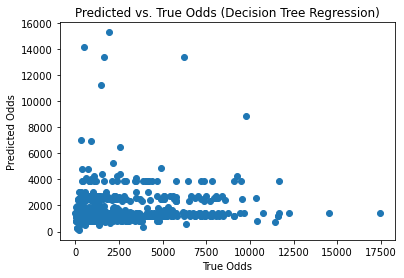

In [76]:
### Visualize result
plt.scatter(y_test, y_predict)
  
# specify title
plt.title('Predicted vs. True Odds (Decision Tree Regression)') 
  
# specify X axis label
plt.xlabel('True Odds')
  
# specify Y axis label
plt.ylabel('Predicted Odds')
  
# show the plot
plt.show()

## Sorry I know this plot is ugly, didn't have time to beautify it

In [77]:
# import export_graphviz
from sklearn.tree import export_graphviz 
  
# export the decision tree to a tree.dot file
# for visualizing the plot easily anywhere
export_graphviz(dt_mse, out_file ='tree.dot') 

#### 4) Feature Importance

Subset for non-text columns --> there are 1,100 text columns

In [78]:
importance = dt_mse.feature_importances_
imp_list = []

# Summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    imp_list.append('Feature: %0d, Score: %.5f' % (i,v))

# Convert imp_list to dataframe
imp_df = pd.DataFrame(imp_list, columns=["Feature"])


### Convert to dataframe for interpretability
imp_df = imp_df["Feature"].str.split(",", expand=True)
imp_df.columns = ["Feature", "Importance"]

imp_df["Importance"] = imp_df["Importance"].str[7:]
imp_df["Importance"] = imp_df["Importance"].astype('float')

# Replace feature numbers with feature names
imp_df["Feature"] = X_train.columns

# Sort by importance
imp_df.sort_values(by=['Importance'])

Feature: 0, Score: 0.00526
Feature: 1, Score: 0.01571
Feature: 2, Score: 0.01631
Feature: 3, Score: 0.12473
Feature: 4, Score: 0.12186
Feature: 5, Score: 0.04284
Feature: 6, Score: 0.00410
Feature: 7, Score: 0.01316
Feature: 8, Score: 0.01946
Feature: 9, Score: 0.00363
Feature: 10, Score: 0.01646
Feature: 11, Score: 0.02290
Feature: 12, Score: 0.00524
Feature: 13, Score: 0.01256
Feature: 14, Score: 0.01378
Feature: 15, Score: 0.03497
Feature: 16, Score: 0.02629
Feature: 17, Score: 0.00709
Feature: 18, Score: 0.00596
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

,Feature,Importance
558,met,0.00000
725,quickly,0.00000
726,rag,0.00000
727,rail,0.00000
728,rails,0.00000
...,...,...
15,maxt,0.03497
5,course_type,0.04284
4,jockey,0.12186
3,weight_carried,0.12473


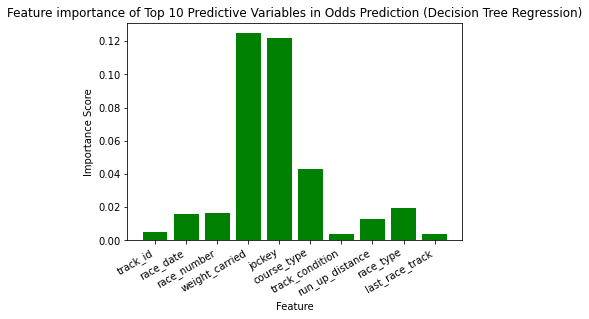

In [81]:
# Plot feature importance
fig, ax = plt.subplots()
plt.bar(imp_df.Feature[:10], imp_df.Importance[:10], color=['r' if v < 0 else 'g' for v in imp_df.Importance])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title("Feature importance of Top 10 Predictive Variables in Odds Prediction (Decision Tree Regression)")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

### Question #3: Predicting the purse of a race

#####  *Model = Random Forest Regression*

#### 1) Split training vs test data

In [82]:
# Retrieve the labels for each of the splits.
y_train = target["purse"].iloc[train_idx]
y_val = target["purse"].iloc[val_idx]
y_test = target["purse"].iloc[test_idx]

# Select the inputs for the different splits.
X_train = data_text.iloc[train_idx]
X_val = data_text.iloc[val_idx]
X_test = data_text.iloc[test_idx]

X_train.head()

,track_id,race_date,race_number,weight_carried,jockey,course_type,track_condition,run_up_distance,race_type,last_race_track,...,wy,xb,xl,yanked,yb,yd,yearly,yes,yield,yielded
14570,2,138,1.0,146.0,109,2,0,0.0,0,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3748,0,183,10.0,122.0,106,3,2,64.0,3,103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,0,11,8.0,122.0,96,0,2,44.0,8,147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4407,0,191,5.0,118.0,77,3,0,36.0,0,103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12584,2,114,1.0,148.0,68,2,0,0.0,8,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2) Fit model

In [ ]:
## Train the Random Forest alg
maes = []
## Hyper parameter tuning --> try between 2-30 trees
for i in range(2,30):
    rf_regressor = RandomForestRegressor(n_estimators=i, 
                                        criterion = "mae", 
                                        max_depth = 10, random_state=0)
    rf_regressor.fit(X_train, y_train)

    # Predict new labels on testing dataset
    y_predict = rf_regressor.predict(X_test)

    # Get MSE 
    mae = mean_absolute_error(y_test, y_predict)
    print("Num trees: ", i, ", MAE: ", mae)

    maes.append(mae)

In [87]:
# Find number of trees and criteria that minimizes MSE
# Find number of trees that maximizes accuracy
max_index = maes.index(max(maes))
num_trees = max_index-2

print("Ideal number of trees that minimizes MAE is: ", num_trees)

Ideal number of trees that minimizes MAE is:  2


In [88]:
# # Run model with optimized number of trees
rf_regressor = RandomForestRegressor(n_estimators = num_trees, random_state=0)
rf_regressor.fit(X_train, y_train)
y_predict = rf_regressor.predict(X_test)

#### Goodness of Fit Metrics

In [89]:
### Get final goodness of fit metrics
mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print("Random forest regression in predicting the purse of a race with 10 trees: ")
print("MAE: ", mae)
print("MSE: ", mse)
print("R2: ", r2)

Random forest regression in predicting the purse of a race with 10 trees: 
MAE:  2611.9946984758117
MSE:  150248343.27369118
R2:  0.990407267584313


#### 4) Feature Importance

In [90]:
importance = rf_regressor.feature_importances_
imp_list = []

# Summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    imp_list.append('Feature: %0d, Score: %.5f' % (i,v))

# Convert imp_list to dataframe
imp_df = pd.DataFrame(imp_list, columns=["Feature"])


### Convert to dataframe for interpretability
imp_df = imp_df["Feature"].str.split(",", expand=True)
imp_df.columns = ["Feature", "Importance"]

imp_df["Importance"] = imp_df["Importance"].str[7:]
imp_df["Importance"] = imp_df["Importance"].astype('float')

# Replace feature numbers with feature names
imp_df["Feature"] = X_train.columns

# Sort by importance
imp_df.sort_values(by=['Importance'])

Feature: 0, Score: 0.00200
Feature: 1, Score: 0.01541
Feature: 2, Score: 0.18071
Feature: 3, Score: 0.01998
Feature: 4, Score: 0.00011
Feature: 5, Score: 0.01338
Feature: 6, Score: 0.00286
Feature: 7, Score: 0.04790
Feature: 8, Score: 0.33970
Feature: 9, Score: 0.00024
Feature: 10, Score: 0.00006
Feature: 11, Score: 0.04563
Feature: 12, Score: 0.00115
Feature: 13, Score: 0.00078
Feature: 14, Score: 0.03449
Feature: 15, Score: 0.03288
Feature: 16, Score: 0.02873
Feature: 17, Score: 0.08223
Feature: 18, Score: 0.00001
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00032
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

,Feature,Importance
558,met,0.00000
725,quickly,0.00000
726,rag,0.00000
727,rail,0.00000
728,rails,0.00000
...,...,...
7,run_up_distance,0.04790
17,weathertype,0.08223
606,none,0.13118
2,race_number,0.18071


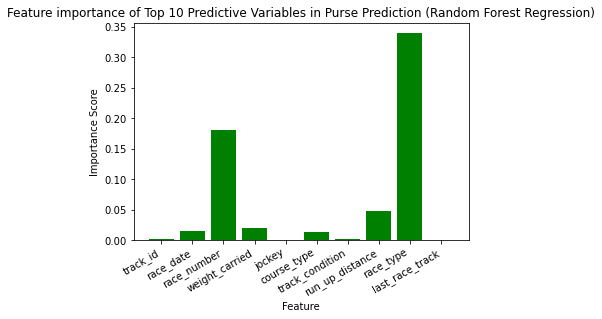

In [91]:
# Plot feature importance
fig, ax = plt.subplots()
plt.bar(imp_df.Feature[:10], imp_df.Importance[:10], color=['r' if v < 0 else 'g' for v in imp_df.Importance])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title("Feature importance of Top 10 Predictive Variables in Purse Prediction (Random Forest Regression)")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

Most important features:
- Race Type
- Race Number
- Run Up Distance
- Course Type
- Weight Carried